In [1]:
import numpy as np
from tslearn.preprocessing import *
from tslearn import metrics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-darkgrid')
%matplotlib inline
%load_ext rpy2.ipython
%R require(dtw)

/home/jgs/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: dtw

  warnings.warn(x, RRuntimeWarning)
/home/jgs/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: proxy

  warnings.warn(x, RRuntimeWarning)
/home/jgs/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘proxy’


  warnings.warn(x, RRuntimeWarning)
/home/jgs/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    as.dist, dist


  warnings.warn(x, RRuntimeWarning)
/home/jgs/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:base’:

    as.matrix


  warnings.warn(x, RRuntimeWarning)
/home/jgs/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWa

array([1], dtype=int32)

In [2]:
df = pd.read_csv('raw_table.txt', names=['idx','start','end', 'curr'])

In [3]:
sl = np.loadtxt('cds_2_only_simu.txt')
rl = df.curr
sl = np.array([i for i in sl for j in range(10)])
rl = np.array([i for i in rl for j in range(30)])

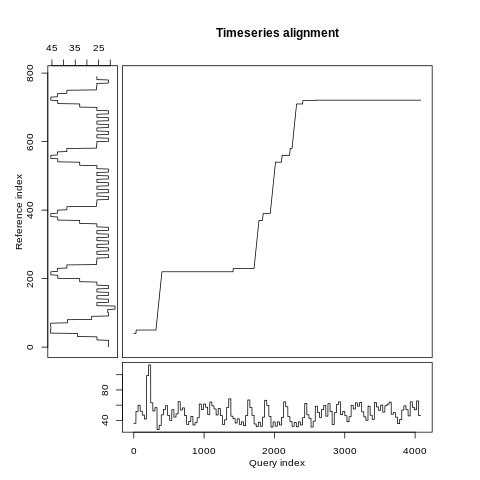

In [4]:
%%R -i sl -i rl
alignmentOBE <-
   dtw(rl,sl,
       keep=TRUE,step=asymmetric,
       open.end=TRUE,open.begin=TRUE);
write.table(data.frame(alignmentOBE$index2),'cds_2_obe.txt', sep = '\t')
plot(alignmentOBE,type="threeway")

In [5]:
obe = pd.read_table('cds_2_obe.txt')

v = obe['alignmentOBE.index2'].tolist()
count = sorted([(i, v.count(i)) for i in set(v)], key=lambda x: x[0])
bound = [i[0] for i in count if i[1] > len(rl)/10]

start = (obe[obe == bound[0]].dropna().index.max()//30) - 5
end = (obe[obe == bound[1]].dropna().index.min()//30)
rl = df.curr[start:end]
rl = np.array([i for i in rl for j in range(10)])
sl = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(sl)[0].T[0]
rl = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(rl)[0].T[0]

In [103]:
bound

[220, 721]

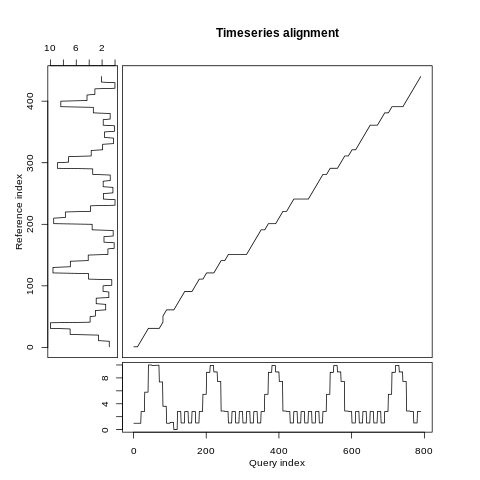

In [6]:
%%R -i sl -i rl
alignmentOBE <-
   dtw(sl,rl,
       keep=TRUE,step=symmetric1);
write.table(data.frame(alignmentOBE$index1,alignmentOBE$index2),'dtw_path.txt', sep = '\t')
plot(alignmentOBE,type="threeway")

/home/jgs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jgs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


analysed deletions are [0, 4, 5, 6, 9, 10, 14, 15, 18, 20, 21, 24, 26, 27, 28, 29, 30, 35, 37, 38, 41, 44, 45, 46, 47, 52, 54, 55, 58, 60, 65, 66, 69, 71, 72, 73], totally 36
deletion rate is 0.45569620253164556
analysed insertions are [4], totally 1
inertions in ref positions are [8]
insertion rate is 0.012658227848101266


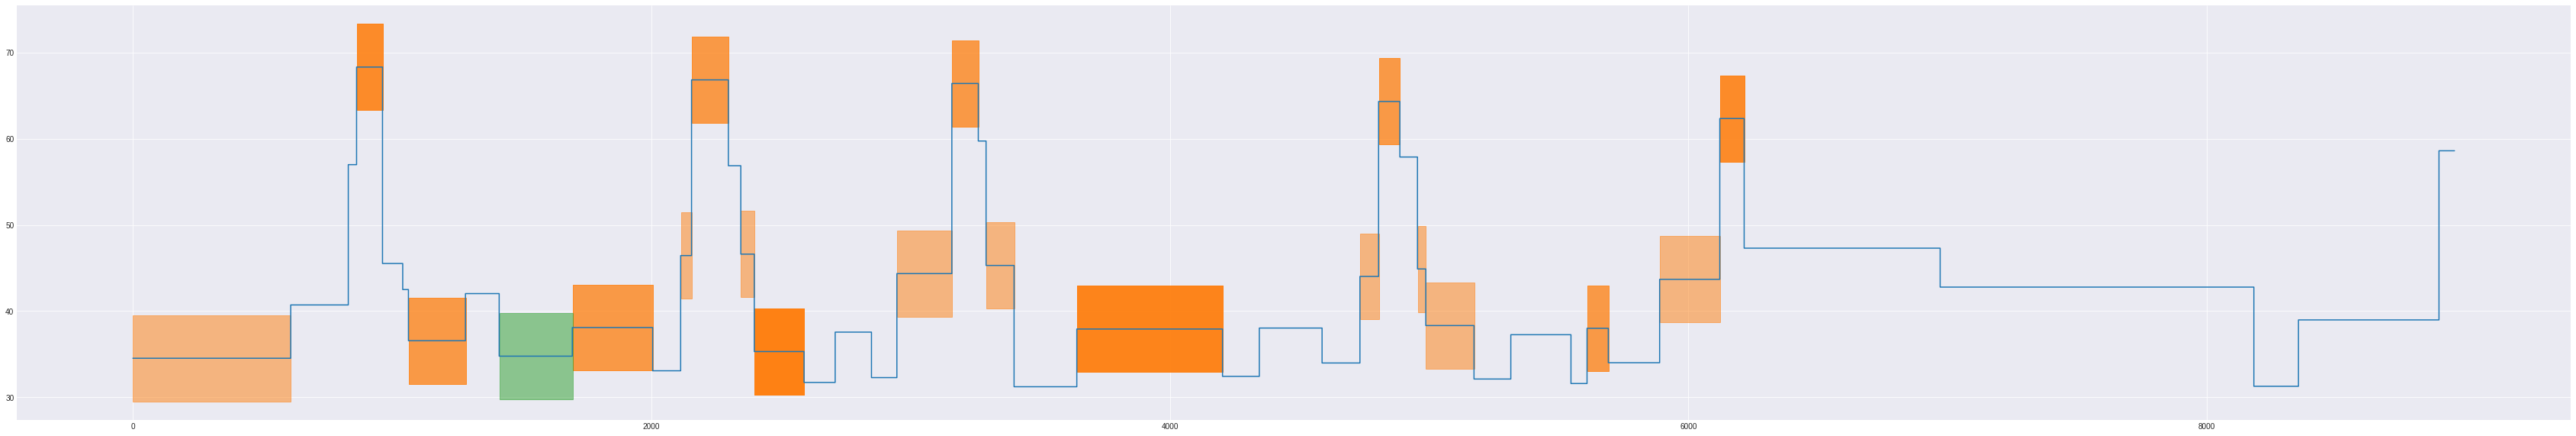

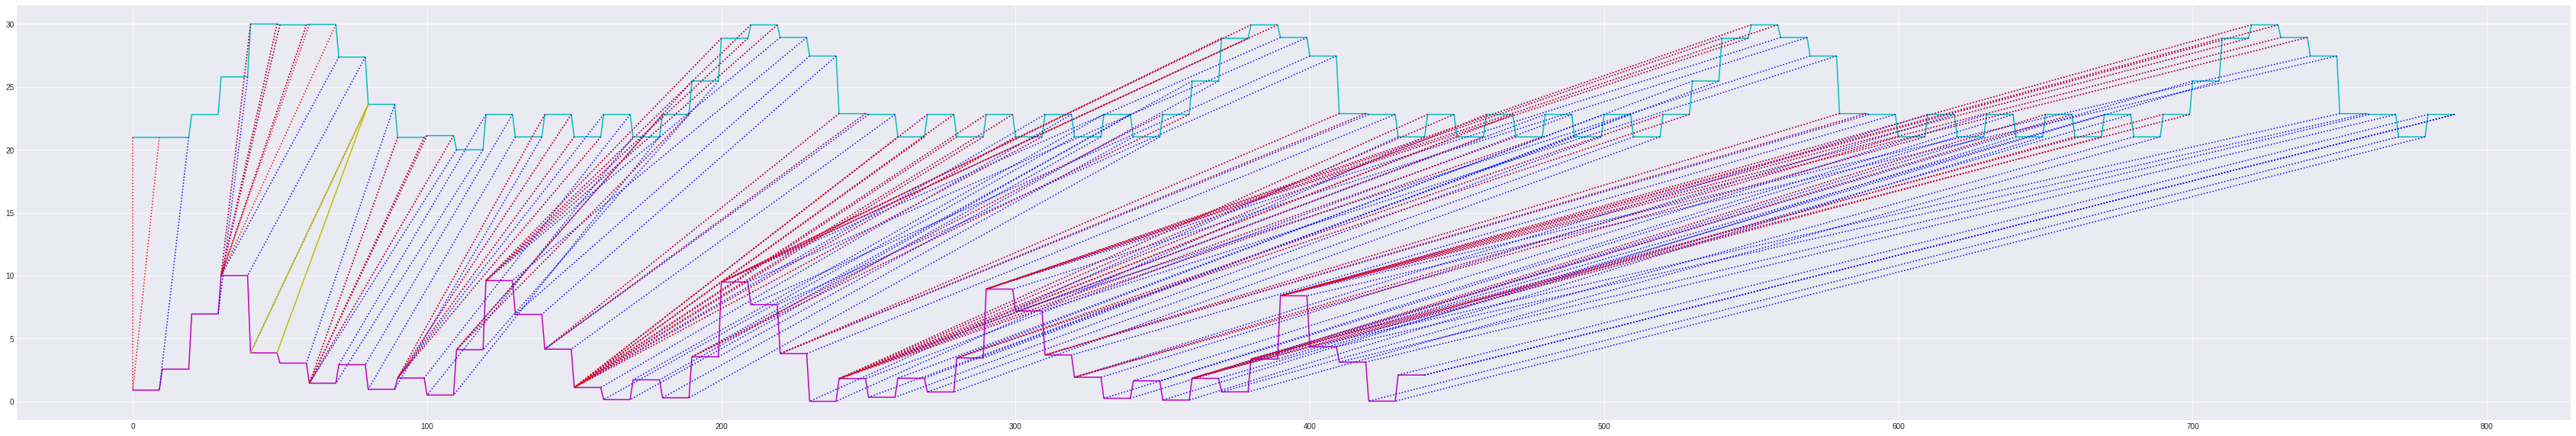

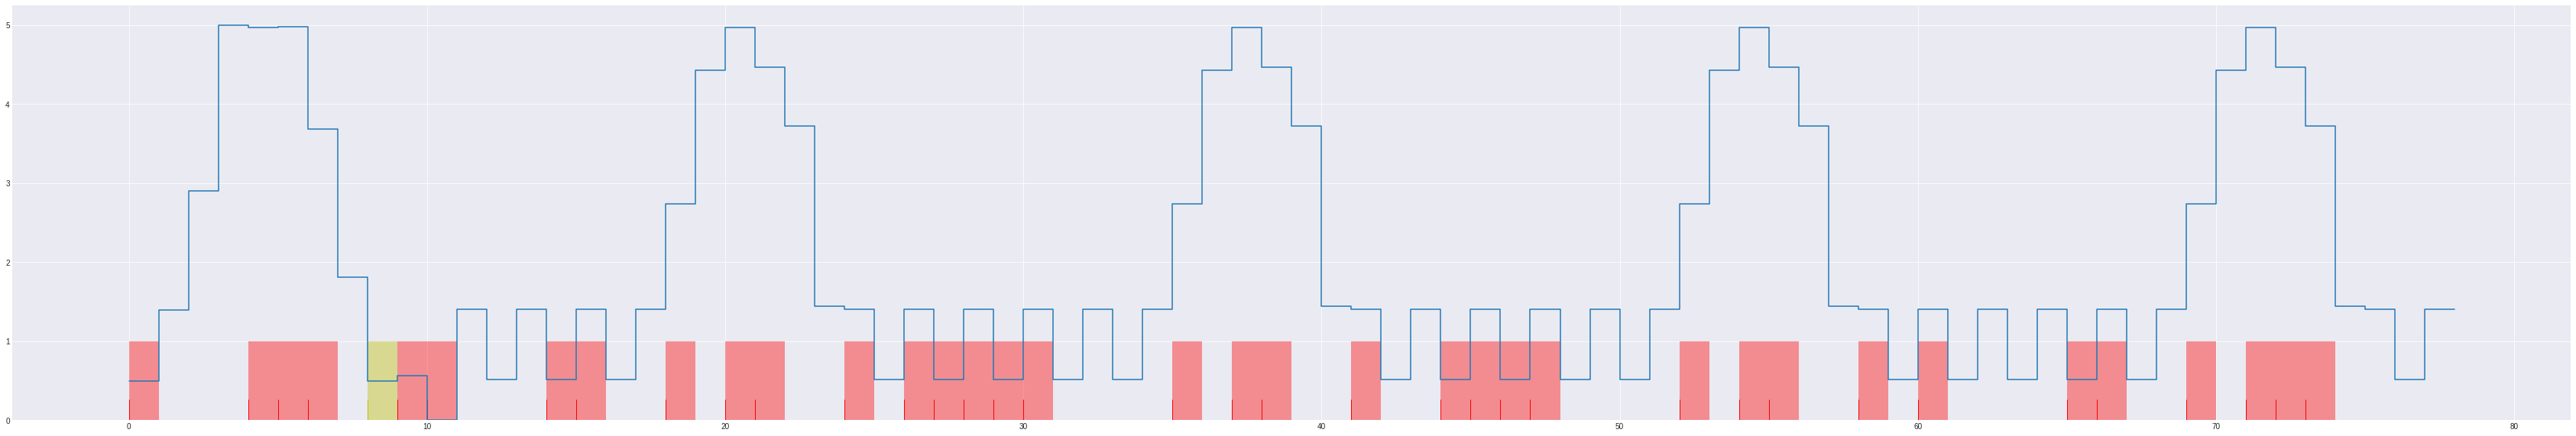

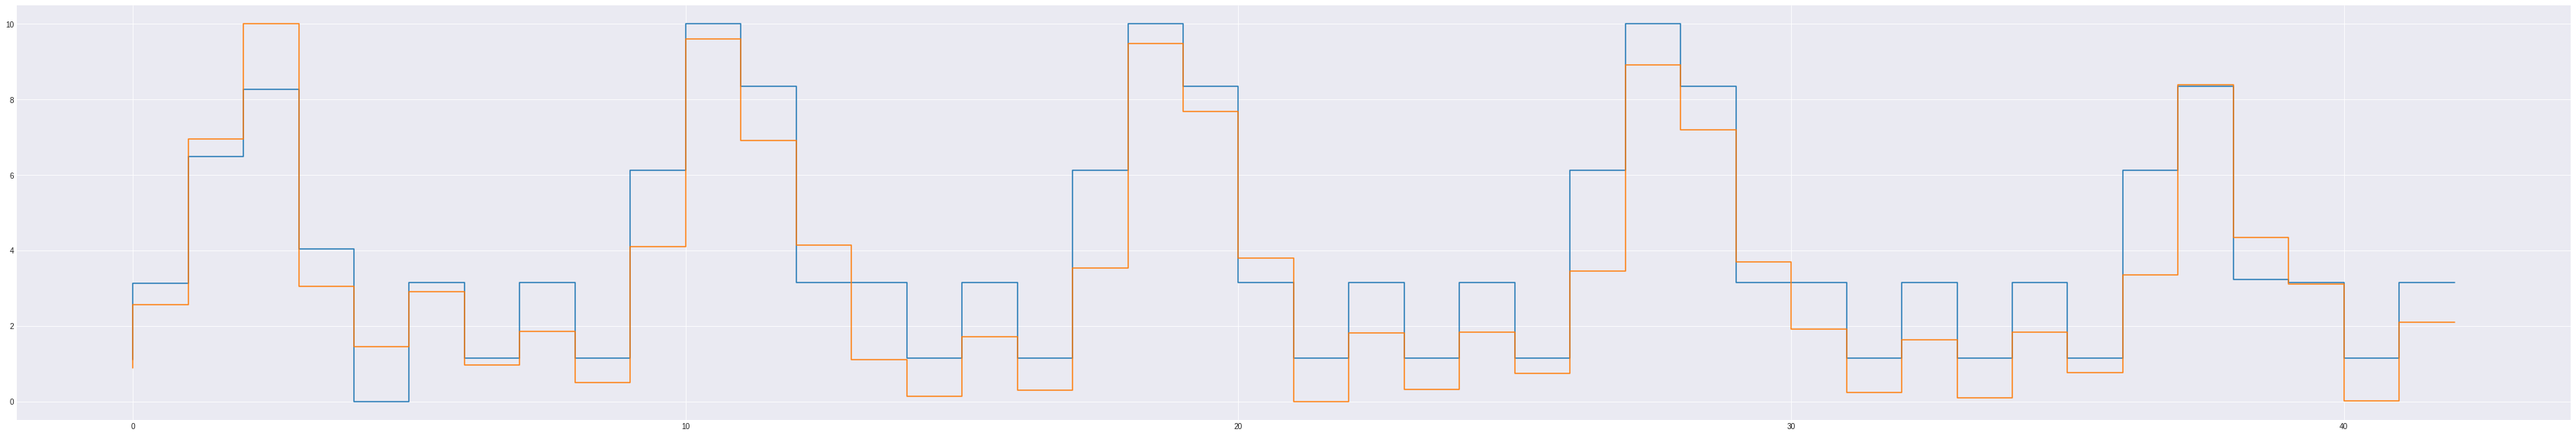

In [58]:
#block test
s_1 = sl; s_2 = rl
n = int(len(sl)/10)
sn = 10
mx = 20
lg = len(sl) - 1





##processing

#path, sim = metrics.dtw_path(s_1, s_2)
path = pd.read_table('dtw_path.txt')

matrix_path = numpy.zeros((len(s_1), len(s_2)), dtype=numpy.int)
for i, j in path.iterrows():
    matrix_path[j[0]-1, j[1]-1] = 1
    
    
deletion = []
deletion_ref = []
for idx, i in enumerate(np.linspace(0,n*sn,n+1)[:n]):
    i = int(i)
    if abs(matrix_path[i+sn-1].argmax() - matrix_path[i].argmax()) < 3:
        deletion = deletion + [idx]
        deletion_ref = deletion_ref + [matrix_path[i+sn-1].argmax()//10]

        

#plt.figure(figsize=(60, 10))
#plt.plot(rl);
#plt.plot(sl);        

df['length'] = df.end - df.start
ts = df.loc[start:end]
offset = ts.iloc[0][1]
ts['start'] = ts['start'] - offset
ts['end'] = ts['end'] - offset
raw = []
for i, j in ts[['curr','length']].iterrows():
    raw = raw + [j[0]] * int(j[1])
    
    
plt.figure(figsize=(60, 10))

plt.step(range(len(raw)), raw);
for i, j in ts[['start', 'end', 'curr']].iloc[deletion_ref,].iterrows():
    plt.fill_betweenx(y=[j[2] - 5, j[2] + 5],
                  x1=j[0], x2=j[1], alpha=0.5, color='C1');
for i, j in ts[['start', 'end', 'curr']].iloc[insertion_ref,].iterrows():
    plt.fill_betweenx(y=[j[2] - 5, j[2] + 5],
                  x1=j[0], x2=j[1], alpha=0.5, color='C2');

plt.figure(figsize=(60, 10))
st = s_1 + mx
plt.plot(st, 'c')
plt.plot(s_2, 'm')

rag = np.linspace(0,n*sn,n+1)
pos = []
for i in rag:
    if i + 9 < lg:
        pos = pos + [i, i + 9]
    else:
        pos = pos + [i, lg]
for i in pos:
    if i not in deletion:
        if i != len(matrix_path):
            #print(i, matrix_path[int(i)].argmax())
            idx = int(matrix_path[int(i)].argmax())
            plt.plot([i, idx], [st[int(i)],s_2[idx]], 'b', linestyle=':')
        else:
            i = i -1
            idx = int(matrix_path[int(i)].argmax())
            plt.plot([i, idx], [st[int(i)],s_2[idx]], 'b', linestyle=':')
        


        

pos1 = []
for i in deletion:
    if i*sn + 9 > sn*n-1:
        pos1 = pos1 + [i*sn, sn*n-1]
    else:
        pos1 = pos1 + [i*10, i*10 + 9]
for i in pos1:
    if i < len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]], 'r', linestyle=':')
    else:
        i = i - 1
        idx = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]], 'r', linestyle=':')
        
#print('real deletions are     %s'%(s[3]))
print('analysed deletions are %s, totally %s'%(deletion, len(deletion)))
print('deletion rate is %s'%(len(deletion)/n))
#inter = set(s[3]).intersection(set(deletion))
#print('TP are                 %s'%(sorted(list(inter))))


insertion = []
insertion_ref = []
matrix_path_t = matrix_path.T
lg = len(rl) - 1
rln = len(rl)//10
for idx, i in enumerate(np.linspace(0,rln*sn,rln+1)[:rln]):
    i = int(i)
    if abs(matrix_path_t[i+sn-1].argmax() - matrix_path_t[i].argmax()) < 3:
        insertion = insertion + [idx]
        insertion_ref = insertion_ref + [matrix_path_t[i+sn-1].argmax()//10]
        
#plt.figure(figsize=(60, 10))
#st = s_1 + mx
#plt.plot(st, 'm')
#plt.plot(s_2, 'c')
pos1 = []
for i in insertion:
    if i*sn + 9 > lg:
        pos1 = pos1 + [lg, lg + 1]
    else:
        pos1 = pos1 + [i*10, i*10 + 9]
for i in pos1:
    if i < len(matrix_path):
        #print(i, matrix_path_t[int(i)].argmax())
        idx = int(matrix_path_t[int(i)].argmax())
        plt.plot([i, idx], [s_2[i], st[int(idx)]], 'y')
    else:
        i = i - 1
        idx = int(matrix_path_t[int(i)].argmax())
        plt.plot([i, idx], [s_2[i], st[int(idx)]], 'y')
        
#print('real insertions are     %s'%(s[3]))
print('analysed insertions are %s, totally %s'%(insertion, len(insertion)))
print('inertions in ref positions are %s' % (insertion_ref))
print('insertion rate is %s'%(len(insertion)/n))
#inter = set(s[3]).intersection(set(insertion))
#print('TP are                 %s'%(sorted(list(inter))))

plt.figure(figsize=(60, 10))
step = TimeSeriesScalerMinMax(min=0, max=5).fit_transform(np.loadtxt('cds_2_only_simu.txt'))[0].T[0]
plt.step(range(len(step)), step)
sns.distplot(deletion, bins=range(n), color='r',kde=False, rug=True);
sns.distplot(insertion_ref, bins=range(n), color='y',kde=False, rug=True);

se = np.loadtxt('cds_2_only_simu.txt')
re = np.array(df.curr)[start:end]
se = se[[i for i in range(len(se)) if (i not in deletion) ]]
re = re[[i for i in range(len(re)) if (i not in insertion)]]
se = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(se)[0].T[0]
re = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(re)[0].T[0]
plt.figure(figsize=(60, 10))
plt.step(range(len(se)), se)
plt.step(range(len(re)), re);

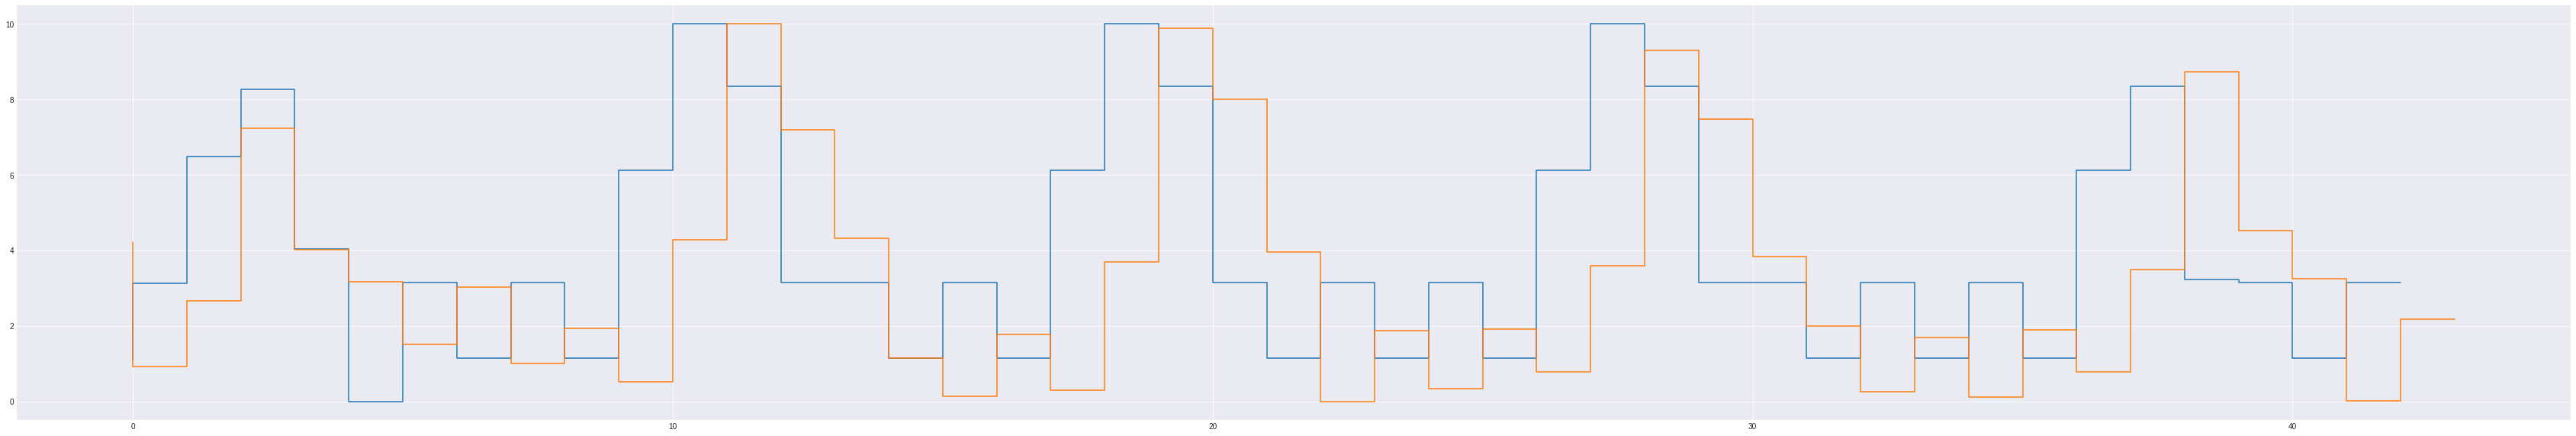

In [165]:
se = np.loadtxt('cds_2_only_simu.txt')
re = np.array(df.curr)[start-1:end]
se = se[[i for i in range(len(se)) if (i not in deletion) ]]
re = re[[i for i in range(len(re)) if (i not in insertion)]]
se = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(se)[0].T[0]
re = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(re)[0].T[0]
plt.figure(figsize=(60, 10))
plt.step(range(len(se)), se)
plt.step(range(len(re)), re);

In [92]:
with open('curr.txt', 'r') as f:
    curr = f.readlines()[start:end]
    curr = [float(t.rstrip()) for i in curr for t in i.split('\t') if t.rstrip()]

/home/jgs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/jgs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


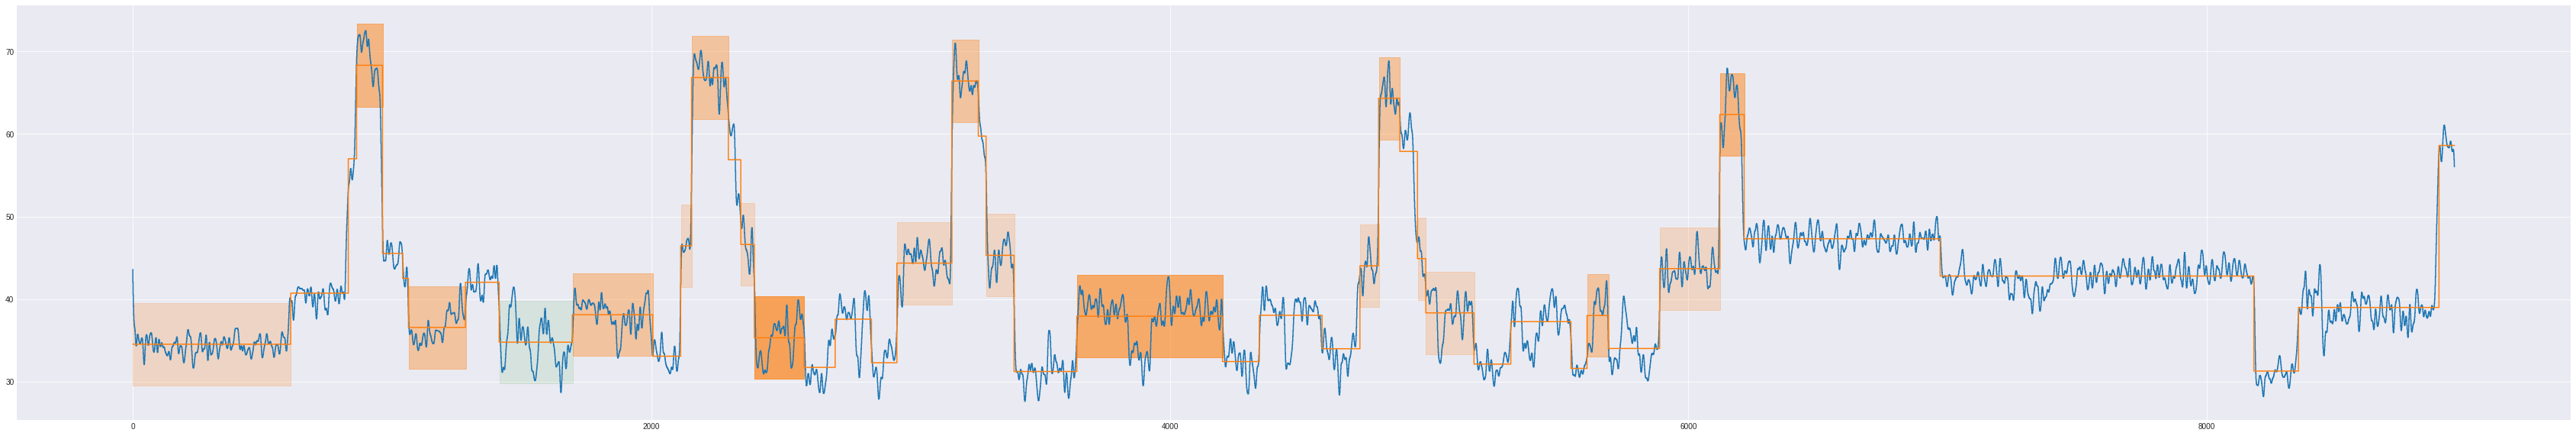

In [102]:
df['length'] = df.end - df.start
ts = df.loc[start:end]
offset = ts.iloc[0][1]
cutpoint = ts.iloc[-1][2]
ts['start'] = ts['start'] - offset
ts['end'] = ts['end'] - offset
curr = np.loadtxt('current0514.txt')[int(offset):int(cutpoint)]
raw = []
for i, j in ts[['curr','length']].iterrows():
    raw = raw + [j[0]] * int(j[1])
plt.figure(figsize=(60, 10))
plt.step(range(len(curr)), curr)
plt.step(range(len(raw)), raw)
for i, j in ts[['start', 'end', 'curr']].iloc[deletion_ref,].iterrows():
    plt.fill_betweenx(y=[j[2] - 5, j[2] + 5],
                  x1=j[0], x2=j[1], alpha=0.2, color='C1');
for i, j in ts[['start', 'end', 'curr']].iloc[insertion_ref,].iterrows():
    plt.fill_betweenx(y=[j[2] - 5, j[2] + 5],
                  x1=j[0], x2=j[1], alpha=0.1, color='C2');
plt.savefig('')

/home/jgs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/jgs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


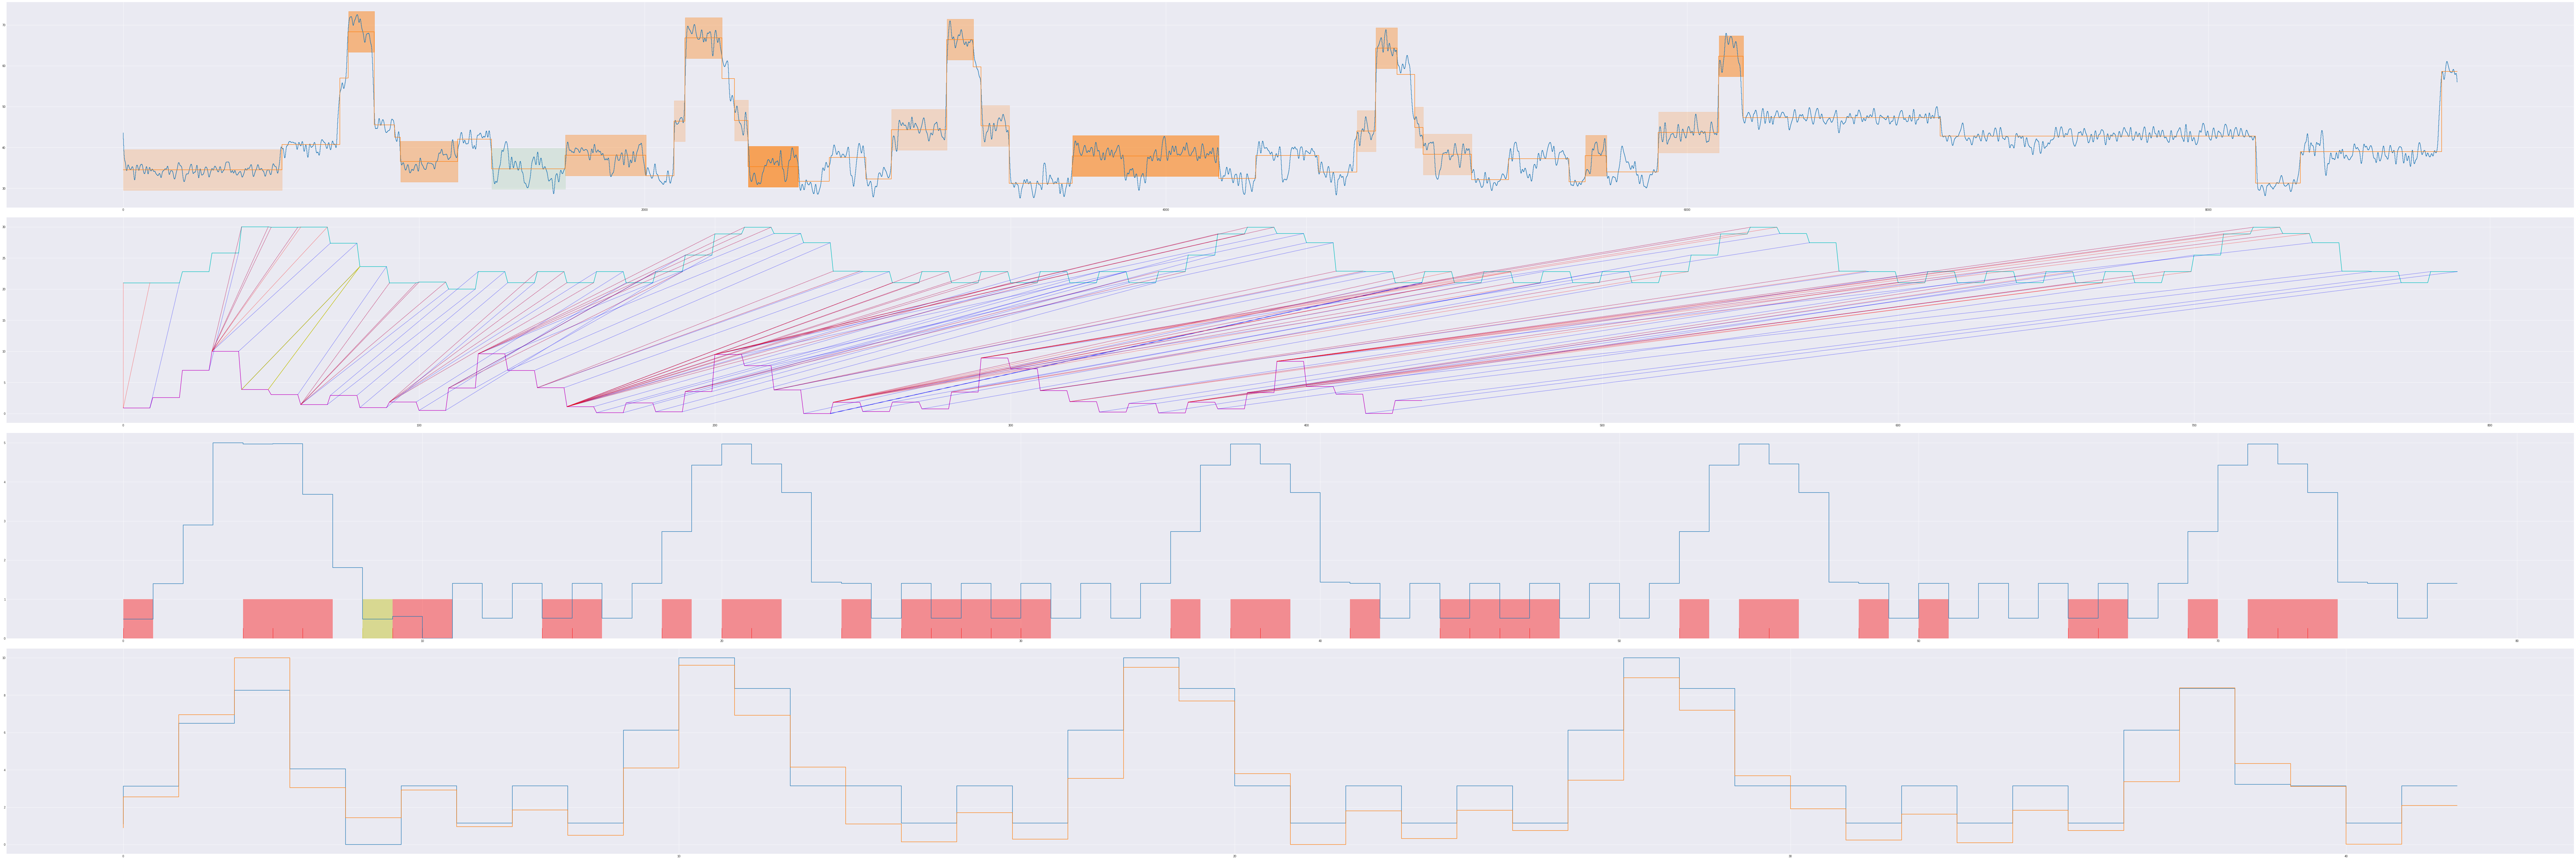

In [116]:
fig = plt.figure(constrained_layout=True, figsize=(120,40))
gs = gridspec.GridSpec(4, 1, figure=fig)
ax = fig.add_subplot(gs[0, :])
df['length'] = df.end - df.start
ts = df.loc[start:end]
offset = ts.iloc[0][1]
cutpoint = ts.iloc[-1][2]
ts['start'] = ts['start'] - offset
ts['end'] = ts['end'] - offset
curr = np.loadtxt('current0514.txt')[int(offset):int(cutpoint)]
raw = []
for i, j in ts[['curr','length']].iterrows():
    raw = raw + [j[0]] * int(j[1])

ax.step(range(len(curr)), curr)
ax.step(range(len(raw)), raw)
for i, j in ts[['start', 'end', 'curr']].iloc[deletion_ref,].iterrows():
    ax.fill_betweenx(y=[j[2] - 5, j[2] + 5],
                  x1=j[0], x2=j[1], alpha=0.2, color='C1');
for i, j in ts[['start', 'end', 'curr']].iloc[insertion_ref,].iterrows():
    ax.fill_betweenx(y=[j[2] - 5, j[2] + 5],
                  x1=j[0], x2=j[1], alpha=0.1, color='C2');

    
ax1 = fig.add_subplot(gs[1, :])
st = s_1 + mx
plt.plot(st, 'c')
plt.plot(s_2, 'm')

rag = np.linspace(0,n*sn,n+1)
pos = []
for i in rag:
    if i + 9 < lg:
        pos = pos + [i, i + 9]
    else:
        pos = pos + [i, lg]
for i in pos:
    if i not in deletion:
        if i != len(matrix_path):
            #print(i, matrix_path[int(i)].argmax())
            idx = int(matrix_path[int(i)].argmax())
            ax1.plot([i, idx], [st[int(i)],s_2[idx]], 'b', linestyle=':')
        else:
            i = i -1
            idx = int(matrix_path[int(i)].argmax())
            ax1.plot([i, idx], [st[int(i)],s_2[idx]], 'b', linestyle=':')
        
pos1 = []
for i in deletion:
    if i*sn + 9 > sn*n-1:
        pos1 = pos1 + [i*sn, sn*n-1]
    else:
        pos1 = pos1 + [i*10, i*10 + 9]
for i in pos1:
    if i < len(matrix_path):
        #print(i, matrix_path[int(i)].argmax())
        idx = int(matrix_path[int(i)].argmax())
        ax1.plot([i, idx], [st[int(i)],s_2[idx]], 'r', linestyle=':')
    else:
        i = i - 1
        ax1 = int(matrix_path[int(i)].argmax())
        plt.plot([i, idx], [st[int(i)],s_2[idx]], 'r', linestyle=':')
insertion = []
insertion_ref = []
matrix_path_t = matrix_path.T
lg = len(rl) - 1
rln = len(rl)//10
for idx, i in enumerate(np.linspace(0,rln*sn,rln+1)[:rln]):
    i = int(i)
    if abs(matrix_path_t[i+sn-1].argmax() - matrix_path_t[i].argmax()) < 3:
        insertion = insertion + [idx]
        insertion_ref = insertion_ref + [matrix_path_t[i+sn-1].argmax()//10]
pos1 = []
for i in insertion:
    if i*sn + 9 > lg:
        pos1 = pos1 + [lg, lg + 1]
    else:
        pos1 = pos1 + [i*10, i*10 + 9]
for i in pos1:
    if i < len(matrix_path):
        #print(i, matrix_path_t[int(i)].argmax())
        idx = int(matrix_path_t[int(i)].argmax())
        ax1.plot([i, idx], [s_2[i], st[int(idx)]], 'y', linestyle=':')
    else:
        i = i - 1
        idx = int(matrix_path_t[int(i)].argmax())
        ax1.plot([i, idx], [s_2[i], st[int(idx)]], 'y', linestyle=':')
        

ax2 = fig.add_subplot(gs[2, :])
step = TimeSeriesScalerMinMax(min=0, max=5).fit_transform(np.loadtxt('cds_2_only_simu.txt'))[0].T[0]
ax2.step(range(len(step)), step)
sns.distplot(deletion, bins=range(n), color='r',kde=False, rug=True, ax=ax2);
sns.distplot(insertion_ref, bins=range(n), color='y',kde=False, rug=True, ax=ax2);

se = np.loadtxt('cds_2_only_simu.txt')
re = np.array(df.curr)[start:end]
se = se[[i for i in range(len(se)) if (i not in deletion) ]]
re = re[[i for i in range(len(re)) if (i not in insertion)]]
se = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(se)[0].T[0]
re = TimeSeriesScalerMinMax(min=0, max=10).fit_transform(re)[0].T[0]
ax3 = fig.add_subplot(gs[3, :])
ax3.step(range(len(se)), se)
ax3.step(range(len(re)), re);

plt.savefig('ins_del_demo.png')

In [114]:
pwd

'/home/jgs/jupyter/ont_data_test'

![img](./ins_del_demo.png)